In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import feature_column
from tensorflow.keras import layers

In [73]:
dataframe = pd.read_csv("./ethusd.csv", usecols=[4], names=["price"], skiprows=1)
dataframeNew = pd.read_csv("./ethusd.csv", usecols=[4,7,8,9,10,11,12,13,14,15,16,17,18,19], names=['close','kama','ppo','pvo','roc','macd','rsi','obv','adi','adx','aroon','stoo','boll_mavg','atr'], skiprows=50)

In [74]:
dataframe.head()

,price
0,2.772120
1,0.753325
2,0.701897
3,0.708448
4,1.067860


In [75]:
dataframeNew.head()

,close,kama,ppo,pvo,roc,macd,rsi,obv,adi,adx,aroon,stoo,boll_mavg,atr
0,0.736223,0.923450,-13.579212,-12.723064,-21.343949,-0.140973,28.901290,-6504737.0,-5.660970e+06,27.838781,-96.0,5.838193,0.982748,0.122810
1,0.785964,0.914750,-13.673968,-15.242475,-10.239350,-0.139402,33.370985,-6135117.0,-5.306283e+06,28.670630,-80.0,22.793951,0.957254,0.119625
2,0.720839,0.899199,-14.215479,-16.668281,-23.673087,-0.141778,30.653805,-6548918.0,-5.700917e+06,29.395340,-88.0,3.423733,0.930964,0.116231
3,0.582886,0.856690,-15.830843,-6.140717,-35.747127,-0.153029,25.851933,-7869808.0,-6.617209e+06,30.868068,-92.0,5.286625,0.897987,0.119972
4,0.661146,0.840180,-16.298015,-3.083363,-24.373993,-0.153856,32.328235,-6955816.0,-5.931692e+06,32.235600,-92.0,26.003837,0.870718,0.119795


In [80]:
dataframeNew

,close,kama,ppo,pvo,roc,macd,rsi,obv,adi,adx,aroon,stoo,boll_mavg,atr
0,0.736223,0.923450,-13.579212,-12.723064,-21.343949,-0.140973,28.901290,-6.504737e+06,-5.660970e+06,27.838781,-96.0,5.838193,0.982748,0.122810
1,0.785964,0.914750,-13.673968,-15.242475,-10.239350,-0.139402,33.370985,-6.135117e+06,-5.306283e+06,28.670630,-80.0,22.793951,0.957254,0.119625
2,0.720839,0.899199,-14.215479,-16.668281,-23.673087,-0.141778,30.653805,-6.548918e+06,-5.700917e+06,29.395340,-88.0,3.423733,0.930964,0.116231
3,0.582886,0.856690,-15.830843,-6.140717,-35.747127,-0.153029,25.851933,-7.869808e+06,-6.617209e+06,30.868068,-92.0,5.286625,0.897987,0.119972
4,0.661146,0.840180,-16.298015,-3.083363,-24.373993,-0.153856,32.328235,-6.955816e+06,-5.931692e+06,32.235600,-92.0,26.003837,0.870718,0.119795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,1935.601074,1783.478243,8.871710,-6.680036,9.477529,149.944851,69.022841,1.234941e+12,1.529547e+12,31.465398,88.0,78.333547,1772.453857,122.700049
1973,1781.992920,1783.446555,7.908499,-3.963375,2.164234,134.203235,56.186023,1.192531e+12,1.535137e+12,29.766826,76.0,44.192242,1785.793817,139.351985
1974,1570.203979,1764.869591,6.129902,0.269751,-11.974114,103.445835,44.027908,1.140501e+12,1.532573e+12,29.455699,76.0,29.107055,1781.258539,158.194842
1975,1626.575684,1758.076427,4.911708,-0.997715,-11.768542,82.666174,47.296920,1.171830e+12,1.537453e+12,29.166796,76.0,37.681408,1782.849188,161.178413


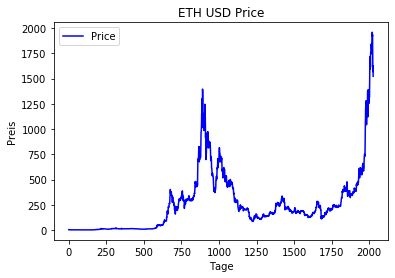

In [76]:
prices = dataframe['price'].to_numpy()

days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.title('ETH USD Price')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

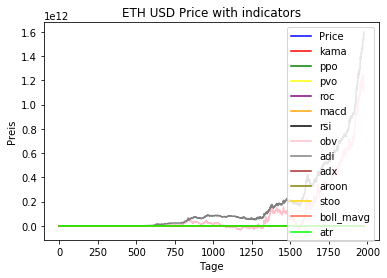

In [78]:
prices = dataframeNew['close'].to_numpy()
kama = dataframeNew['kama'].to_numpy()
ppo = dataframeNew['ppo'].to_numpy()
pvo = dataframeNew['pvo'].to_numpy()
roc = dataframeNew['roc'].to_numpy()
macd = dataframeNew['macd'].to_numpy()
rsi = dataframeNew['rsi'].to_numpy()
obv = dataframeNew['obv'].to_numpy()
adi = dataframeNew['adi'].to_numpy()
adx = dataframeNew['adx'].to_numpy()
aroon = dataframeNew['aroon'].to_numpy()
stoo = dataframeNew['stoo'].to_numpy()
boll_mavg = dataframeNew['boll_mavg'].to_numpy()
atr = dataframeNew['atr'].to_numpy()

days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.plot(days, kama, 'red', label='kama')
plt.plot(days, ppo, 'green', label='ppo')
plt.plot(days, pvo, 'yellow', label='pvo')
plt.plot(days, roc, 'purple', label='roc')
plt.plot(days, macd, 'orange', label='macd')
plt.plot(days, rsi, 'black', label='rsi')
plt.plot(days, obv, 'pink', label='obv')
plt.plot(days, adi, 'grey', label='adi')
plt.plot(days, adx, 'brown', label='adx')
plt.plot(days, aroon, 'olive', label='aroon')
plt.plot(days, stoo, 'gold', label='stoo')
plt.plot(days, boll_mavg, 'tomato', label='boll_mavg')
plt.plot(days, atr, 'lime', label='atr')
plt.title('ETH USD Price with indicators')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

In [79]:
features = []
labels = []

for i in range(20, len(prices)):
    if (i+1 <= len(prices)-1):
        feature = prices[i-20:i]
        normalized_prices = []
        
        for q in range(20):
            normalized_prices.append(feature[q] / feature[0])
        
        features.append(normalized_prices)
        
        next_price = prices[i]
        
        if (next_price > prices[i+1]):
            labels.append([1])
        else:
            labels.append([0])
            

In [83]:
features = []
labels = []

for i in range(20, len(prices)):
    if (i+1 <= len(prices)-1):
        feature = []
        prices_n = prices[i-20:i]
        kama_n = kama[i-20:i]
        ppo_n = ppo[i-20:i]
        pvo_n = pvo[i-20:i]
        roc_n = roc[i-20:i]
        macd_n = macd[i-20:i]
        rsi_n = rsi[i-20:i]
        obv_n = obv[i-20:i]
        adi_n = adi[i-20:i]
        adx_n = adx[i-20:i]
        aroon_n = aroon[i-20:i]
        stoo_n = stoo[i-20:i]
        boll_mavg_n = boll_mavg[i-20:i]
        atr_n = atr[i-20:i]
        normalized_prices = []
        normalized_kama = []
        normalized_ppo = []
        normalized_pvo = []
        normalized_roc = []
        normalized_macd = []
        normalized_rsi = []
        normalized_obv = []
        normalized_adi = []
        normalized_adx = []
        normalized_aroon = []
        normalized_stoo = []
        normalized_boll_mavg = []
        normalized_atr= []
    
        for q in range(20):
            normalized_prices.append(prices_n[q] / prices_n[0])
            #normalized_kama.append(kama_n[q] / kama_n[0])
            #normalized_ppo.append(ppo_n[q] / ppo_n[0])
            #normalized_pvo.append(pvo_n[q] / pvo_n[0])
            #normalized_roc.append(roc_n[q] / roc_n[0])
            normalized_macd.append(macd_n[q] / macd_n[0])
            #normalized_rsi.append(rsi_n[q] / rsi_n[0])
            #normalized_obv.append(obv_n[q] / obv_n[0])
            #normalized_adi.append(adi_n[q] / adi_n[0])
            #normalized_adx.append(adx_n[q] / adx_n[0])
            #normalized_aroon.append(aroon_n[q] / aroon_n[0])
            #normalized_stoo.append(stoo_n[q] / stoo_n[0])
            #normalized_boll_mavg.append(boll_mavg_n[q] / boll_mavg_n[0])
            #normalized_atr.append(atr_n[q] / atr_n[0])
            
        feature.append(normalized_prices)
        #feature.append(normalized_kama)
        #feature.append(normalized_ppo)
        #feature.append(normalized_pvo)
        #feature.append(normalized_roc)
        feature.append(normalized_macd)
        #feature.append(normalized_rsi)
        #feature.append(normalized_obv)
        #feature.append(normalized_adi)
        #feature.append(normalized_adx)
        #feature.append(normalized_aroon)
        #feature.append(normalized_stoo)
        #feature.append(normalized_boll_mavg)
        #feature.append(normalized_atr)
    
        
        features.append(feature)
        
        next_price = prices[i]
        
        label = []
        for j in range(2):
            if (next_price > prices[i+1]):
                label.append([1])
            else:
                label.append([0])
        labels.append(label)

In [84]:
for i in range(3):
    print(features[i])
    print(labels[i])

[[1.0, 1.0675624097589997, 0.9791041573001659, 0.7917247899074058, 0.8980241041097603, 1.0032884058226923, 0.9375080648118844, 0.921696279524003, 0.9333734479906224, 0.9078485730546315, 0.8538757957847012, 0.8837607627036917, 0.8277220353072372, 0.8444669617765269, 0.8837376718738752, 0.8528081844767142, 0.8624601513400153, 0.850326599413493, 0.8253681289500601, 0.7103391227929582], [1.0, 0.9888584401822896, 1.005712481745037, 1.085519445877187, 1.0913907609411952, 1.039699568114767, 1.014756817417962, 0.9902378783518491, 0.9548783444541225, 0.9269270137890424, 0.9169499273217516, 0.8862332976599341, 0.8754140993668389, 0.8499852560413894, 0.8040155236616998, 0.771722187050032, 0.7336055190986257, 0.7004367647341908, 0.6768655085027536, 0.6986061905045601]]
[[1], [1]]
[[1.0, 0.9171399707874661, 0.7416192090222962, 0.8411911995969281, 0.9397936801176644, 0.8781763541332681, 0.8633652431918002, 0.8743034032093072, 0.850393911171504, 0.799836888203531, 0.8278305367675873, 0.77533831066053

In [85]:
def numpy_to_ds(features, labels, batch_size):
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

In [86]:
dataset = numpy_to_ds(features, labels, 1)

In [87]:
dataset = dataset.shuffle(len(features))

In [88]:
DATASET_SIZE = len(features)

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = dataset.skip(test_size)
test_ds = dataset.take(test_size)

In [89]:
text_batch, label_batch = next(iter(train_ds))
print(text_batch, label_batch)

tf.Tensor(
[[[ 1.          1.10411592  1.0439265   1.05688098  1.05854786
    1.03517994  1.06519554  1.02204513  1.00222458  1.01582362
    1.00474604  1.00397853  0.99555627  0.99650066  0.97012335
    0.91182186  0.90333787  0.93164743  0.91585135  0.92054584]
  [ 1.          0.68559344  0.16970147 -0.18008544 -0.44483392
   -0.74880995 -0.84790386 -1.1035294  -1.3774247  -1.51717896
   -1.65755694 -1.75198788 -1.84263288 -1.88854547 -2.01770344
   -2.34944068 -2.61946932 -2.67806736 -2.7621515  -2.77613671]]], shape=(1, 2, 20), dtype=float64) tf.Tensor(
[[[1]
  [1]]], shape=(1, 2, 1), dtype=int32)


In [90]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [91]:
model = tf.keras.Sequential([
  layers.Reshape((2, 20)),
  layers.LSTM(64, return_sequences=True),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
1369/1369 [==============================] - 6s 3ms/step - loss: 0.7023 - binary_accuracy: 0.5026 - val_loss: 0.6923 - val_binary_accuracy: 0.5153
Epoch 2/10
1369/1369 [==============================] - 3s 2ms/step - loss: 0.6947 - binary_accuracy: 0.5086 - val_loss: 0.6923 - val_binary_accuracy: 0.5173
Epoch 3/10
1369/1369 [==============================] - 3s 2ms/step - loss: 0.6935 - binary_accuracy: 0.5077 - val_loss: 0.6928 - val_binary_accuracy: 0.5157
Epoch 4/10
1369/1369 [==============================] - 3s 2ms/step - loss: 0.6955 - binary_accuracy: 0.5094 - val_loss: 0.6924 - val_binary_accuracy: 0.5157
Epoch 5/10
1369/1369 [==============================] - 3s 2ms/step - loss: 0.6935 - binary_accuracy: 0.5141 - val_loss: 0.6926 - val_binary_accuracy: 0.5141
Epoch 6/10
1369/1369 [==============================] - 3s 3ms/step - loss: 0.6936 - binary_accuracy: 0.5108 - val_loss: 0.6934 - val_binary_accuracy: 0.5147
Epoch 7/10
1369/1369 [==============================

In [92]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

391/391 [==============================] - 0s 894us/step - loss: 0.6970 - binary_accuracy: 0.4936
Loss:  0.6970403790473938
Accuracy:  0.4936061501502991


In [93]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

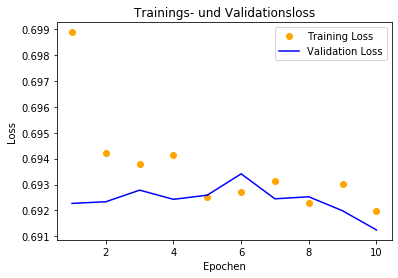

In [94]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.title('Trainings- und Validationsloss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.show()

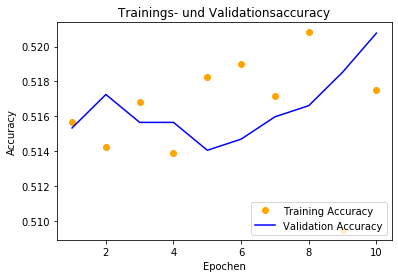

In [95]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'o', color='orange', label='Training Accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
plt.title('Trainings- und Validationsaccuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [96]:
feature_batch, label_batch = next(iter(test_ds))
print(feature_batch)

model.predict(feature_batch)

tf.Tensor(
[[[1.         1.06635074 1.15693705 1.0959956  1.13118333 1.12235984
   1.1128246  1.16818178 1.11284077 1.14433087 1.11097698 1.11854718
   1.11707965 1.15260837 1.14937616 1.21455194 1.43219793 1.61630336
   1.57524328 1.82046301]
  [1.         0.98745424 1.11532119 1.10258679 1.13790311 1.13809674
   1.10960008 1.16565133 1.10528624 1.09717434 1.0234723  0.96651257
   0.90845859 0.91104106 0.89736749 0.98359541 1.39781486 2.00913719
   2.39768301 3.07798521]]], shape=(1, 2, 20), dtype=float64)


array([[[-0.14952512],
        [-0.15293345]]], dtype=float32)